# Dimensionality Reduction

##PART1) Apply various dimensionality reduction techniques for 2D visualization of MNIST data set

In [7]:
# common imports
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (15.0, 8.0)

In [2]:
# load data
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
X_mnist = mnist['data']
y_mnist = mnist['target']
X_train, X_test = X_mnist[:60000], X_mnist[-10000:]
y_train,  y_test = y_mnist[:60000], y_mnist[-10000:]


#### dimensionality on whole data make take time, so use a subsample of data for now

In [3]:
np.random.seed(42)
m = 5000
idx = np.random.permutation(60000)[:m]
X = X_mnist[idx]
y = y_mnist[idx]


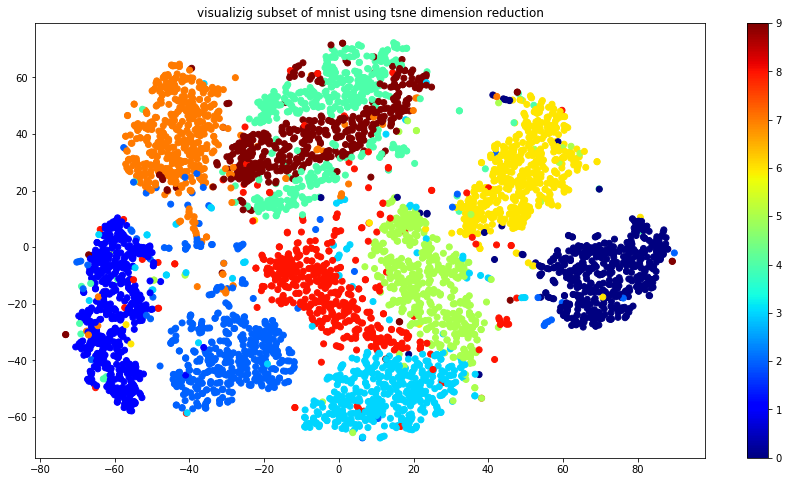

In [8]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2,random_state = 42)
X_reduced = tsne.fit_transform(X)
plt.figure()
plt.title("visualizig subset of mnist using tsne dimension reduction")
plt.scatter(X_reduced[:,0], X_reduced[:,1], c = y, cmap = plt.get_cmap('jet'))
plt.colorbar()

#### from this visualization. it is obviouse that 4s and 9 have seriouse overlap, 3s are all over, (0,1,6) are well seperated 

#### now, same figure in a fancier format

In [14]:
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_digit(X_reduced_0, y, X = None, min_dis = .6):
    ''' plot a 2d plot with the option to write colored digits on far enough data points
    or use the hand written digits themselves.'''
    plt.figure()
    # normalize data
    X_reduced= MinMaxScaler().fit_transform(X_reduced_0)
    # points that we are going to plot their digit
    #  a far point for start
    plot_points = np.array([[100,100]])
    cmap = plt.get_cmap('jet')
    # first like before plot scatter plot
    plt.scatter(X_reduced[:,0], X_reduced[:,1], c = y, cmap = plt.get_cmap('jet'))
    plt.colorbar()
    # on the same axis
    ax = plt.gcf().gca()
    for index in range(len(X_reduced)):
        # if a point is far away all points that are going to be plotted
        # add it to the list and then add its digit
        if (euclidean_distances(X_reduced[index:index+1], plot_points)).min() > min_dis:
            plot_points = np.r_[plot_points, X_reduced[index: index+1]]

            if X is None:
                # if X is not given use colored digits on the figure
                plt.text(X_reduced[index:index+1,0], X_reduced[index:index+1,1],
                y[index], color = cmap(y[index]/ 9.) ,
                fontdict={"weight": "bold", "size": 16})
            else:
                # if X is given, plot the hand written digits themself on figure
                image = X[index].reshape(28,28)
                imagebox = AnnotationBbox(\
                OffsetImage(image,zoom=.6, cmap = 'binary'), X_reduced[index],
                pad = .1)
                ax.add_artist(imagebox )


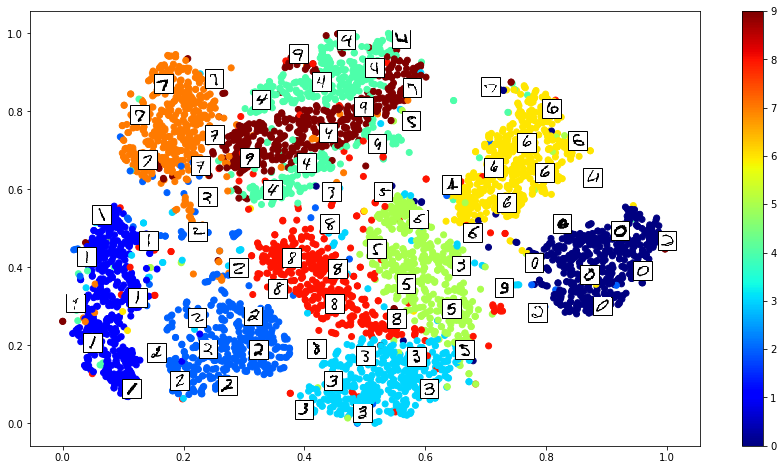

In [17]:
# replot the results of t-sne again
plot_digit(X_reduced, y, X , min_dis = .08)

### lets use other dimensionality techniques to see how they work for visualizatin

In [18]:
from sklearn.decomposition import  PCA
from sklearn.decomposition import KernelPCA
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import MDS
from sklearn.manifold import Isomap

tsne = TSNE(n_components=2,random_state = 42)
pca = PCA(n_components=2, random_state = 42)
kernel_pca = KernelPCA(n_components=2, kernel='cosine',random_state =42)
lda = LinearDiscriminantAnalysis(n_components=2)
lle = LocallyLinearEmbedding(n_components=2, random_state = 42)
mds = MDS(n_components=2, random_state = 42)
isomap = Isomap(n_components=2)

time takes for PCA	0.146352052689
time takes for KernelPCA	1.28755402565
time takes for LocallyLinearEmbedding	36.0146100521
time takes for LinearDiscriminantAnalysis	0.918547153473
time takes for Isomap	50.6250889301
time takes for TSNE	149.187306166


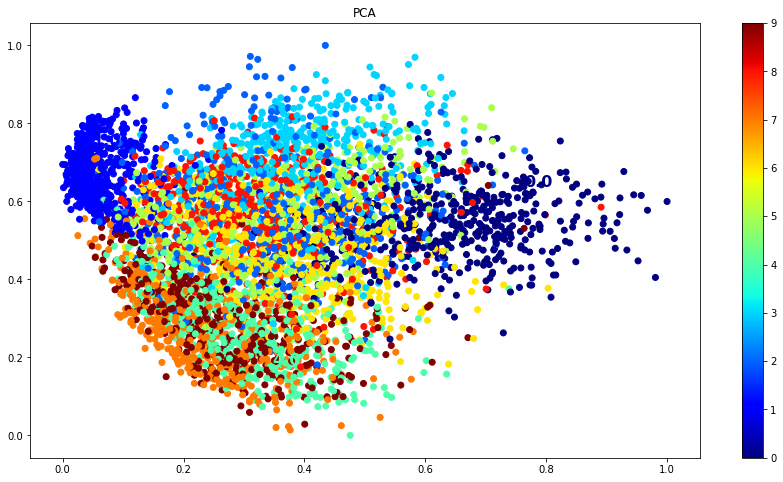

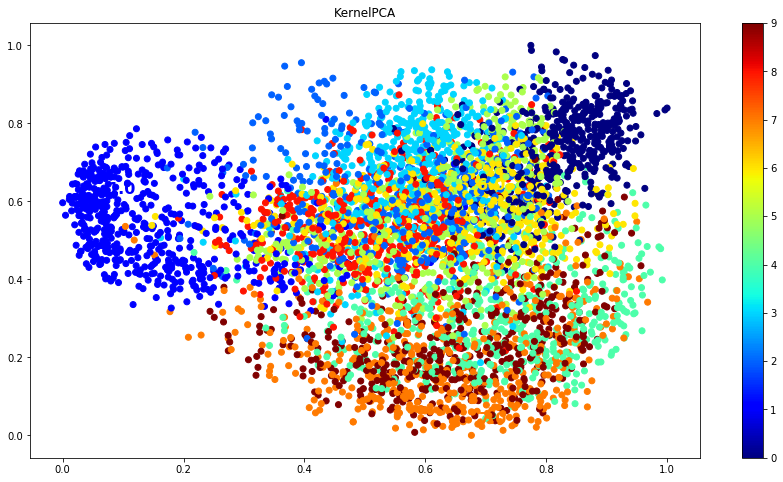

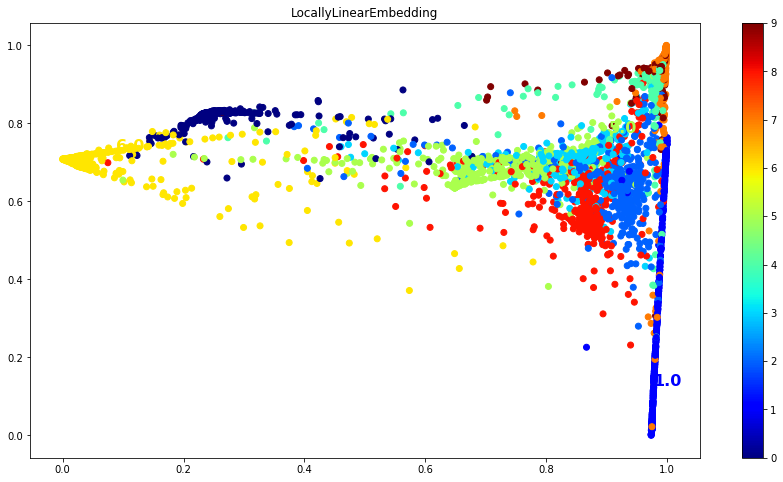

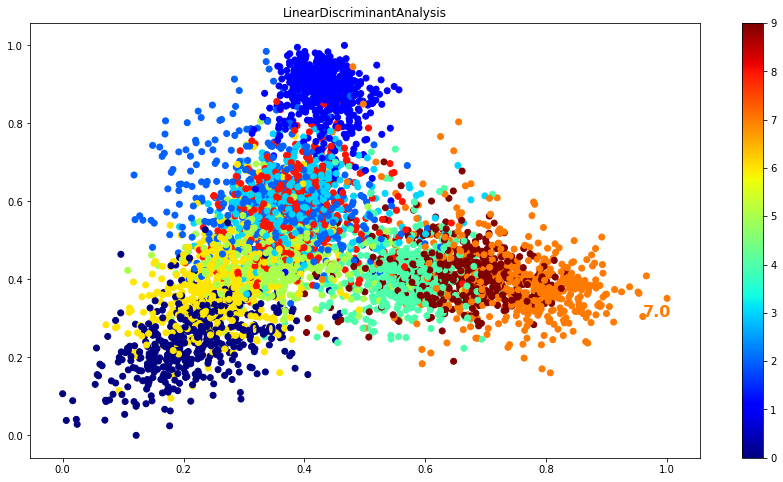

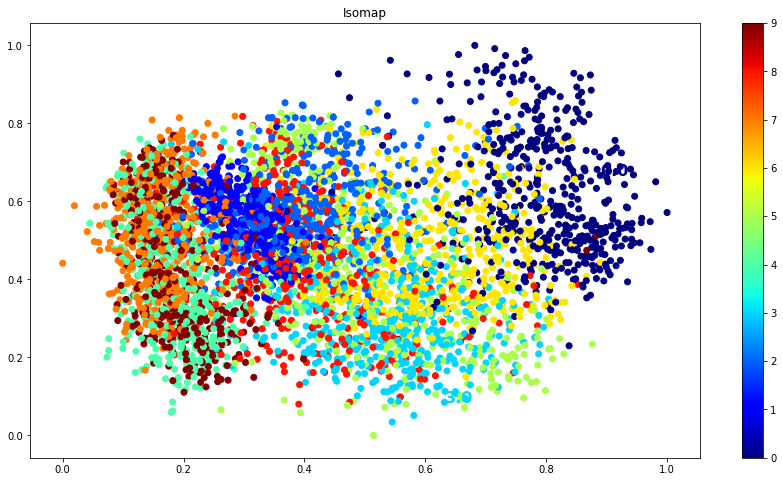

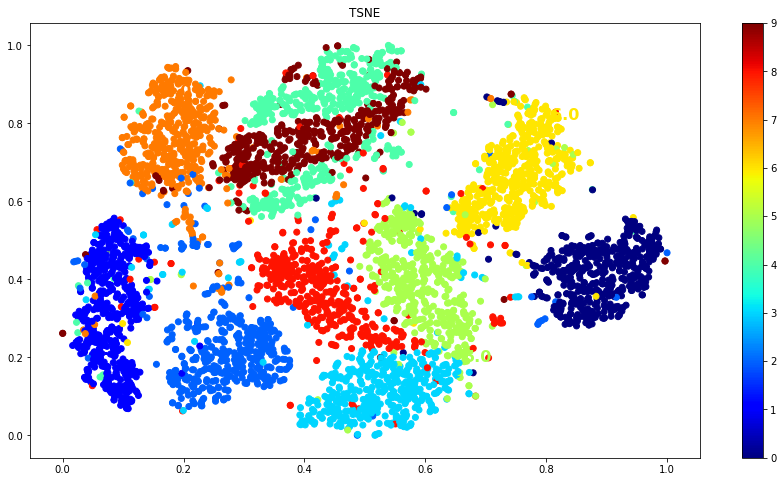

In [23]:
import time
for technique in (pca, kernel_pca,  lle ,lda, isomap, tsne):
    s1 = time.time()
    X_reduced = technique.fit_transform(X, y)
    s2 = time.time()
    print "time takes for " + str(technique.__class__.__name__) +"\t"+ str(s2 - s1)
    plt.figure()
    plot_digit(X_reduced, y)
    plt.title(technique.__class__.__name__)

#### among all, t-sne does a great job at seperating classes but after MDS it is the slowest( I kill MDS it was too slow)
#### so lets first use PCA  twith preserveing .95 of variance and quickly reduce dimension and then tsne


pca + tsne take time 114.303485155


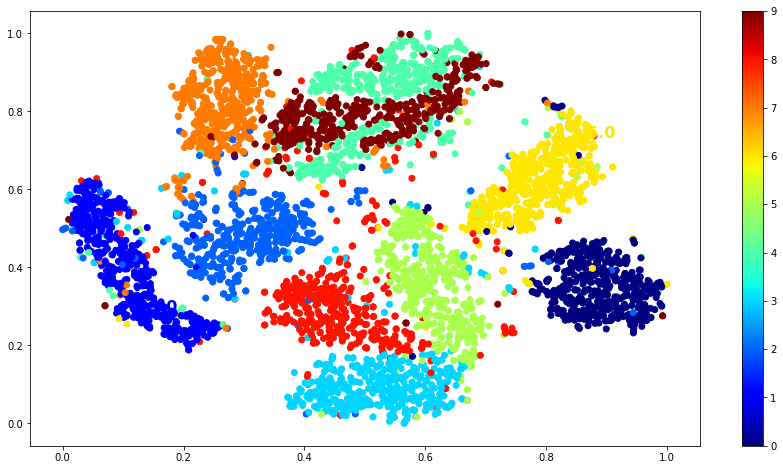

In [24]:
from sklearn.pipeline import Pipeline

pca = PCA(n_components=.95, random_state = 42)
pca_tsne = Pipeline([('PCA',pca),('t_SNE', tsne)])
s1 = time.time()
X_reduced = pca_tsne.fit_transform(X)
s2 = time.time()
print "pca + tsne take time", (s2 - s1)
plot_digit(X_reduced, y)

#### results of tsne and PCA+tsne are quiet alike but by using PCA slightly speed up the process

## PART 2) apply dimensionality reduction as a prestep before classifying mnist data set and see the results

train a Random Forest classifier on the dataset and check speed and performance(accuracy) on test data

In [25]:
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=10, max_features = 'auto',
random_state =42)
s1 = time.time()
rnd_clf.fit(X_train, y_train)
s2 = time.time()
print "time of training rdforest on original data",(s2 - s1)
print "accuracy of model trained on original data",rnd_clf.score(X_test, y_test)

time of training rdforest on original data 5.15136909485
accuracy of model trained on original data 0.9455


In [26]:
pca = PCA(n_components = .95, random_state =42)
s3 = time.time()
X_reduced = pca.fit_transform(X_train)
s4 = time.time()
print "time for perform PCA", s4 - s3
rnd_clf = RandomForestClassifier(n_estimators=10, max_features = 'auto',
random_state =42)
s5 = time.time()
rnd_clf.fit(X_reduced, y_train)
s6 = time.time()
print "time of training rdforest on reduced data",(s6 - s5)
X_reduced_test = pca.transform(X_test)
print "accuracy of model trained on reduced data",\
rnd_clf.score(X_reduced_test, y_test)

time for perform PCA 11.4918010235
time of training rdforest on reduced data 9.77241110802
accuracy of model trained on reduced data 0.8908


as it turns, using dimensionality reduction does not lead to a faster training process and performance drops significantly as well
now, lets use linear classifier instead of random forest for classification

In [28]:
# without PCA
from sklearn.linear_model import LogisticRegression
log_clf = LogisticRegression(multi_class="multinomial", solver="lbfgs",
 random_state=42)
s1 = time.time()
log_clf.fit(X_train, y_train)
s2 = time.time()
print "time of training rdforest on original data",(s2 - s1)
print "accuracy of model trained on original data",log_clf.score(X_test, y_test)


time of training rdforest on original data 20.4709119797
accuracy of model trained on original data 0.9252


In [29]:
# using PCA
log_clf = LogisticRegression(multi_class="multinomial", solver="lbfgs",
 random_state=42)
s5 = time.time()
log_clf.fit(X_reduced, y_train)
s6 = time.time()
print "time of training rdforest on reduced data",(s6 - s5)
print "accuracy of model trained on reduced data",\
log_clf.score(X_reduced_test, y_test)

time of training rdforest on reduced data 6.93256187439
accuracy of model trained on reduced data 0.9198


using PCA befor loggistic regression leads to a faster training time and performance drop slightly which is natural, because we are losing some information